# Desafio 4 - LSTM Bot QA

## Importación de librerías

In [41]:
import re
import os
import zipfile

import numpy as np
import pandas as pd
import gdown
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.config import list_physical_devices
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.regularizers import l2
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model

In [42]:
gpus = list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {gpus}")
else:
    print("No GPU detected. Using CPU instead.")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Carga de datos

In [43]:
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [44]:
text_file = "data_volunteers.json"

with open(text_file) as f:
    data = json.load(f)

In [45]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

## Data preparation

Se comienza la preparación de los datos realizando una limpieza y separación de estos.

In [231]:
# Initialize lists for the input and output sequences
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []

max_length = 10

def clean_text(txt):
    # Convert text to lowercase
    txt = txt.lower()
    
    # Replace common contractions
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    
    # Remove all non-alphanumeric characters
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog']) - 1):
        # Clean and extract the input and output sentences
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i + 1]['text'])

        # If either sentence exceeds the maximum allowed length, skip them
        if len(chat_in) >= max_length or len(chat_out) >= max_length:
            continue
        
        # Assign the cleaned sentences to input and output variables
        input_sentence, output = chat_in, chat_out
        
        # Add the <eos> token to the end of the output sentence
        output_sentence = output + ' <eos>'
        # Add the <sos> token to the beginning of the output sentence
        output_sentence_input = '<sos> ' + output

        # Append the processed sentences to their respective lists
        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

# Print the number of rows (sentence pairs) used in total
print("Number of total rows:", len(data))
print("Number of rows used:", len(input_sentences))

Number of total rows: 1111
Number of rows used: 388


In [232]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi ', 'hello  <eos>', '<sos> hello ')

Se tokeniza el texto de entrada para obtener los valores de `word2idx_inputs` y `max_input_len`.

In [233]:
# Define the maximum vocabulary size
MAX_VOCAB_SIZE = 8000

# Tokenizer for input sentences
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)

# Convert input sentences to sequences of integers
input_integer_sequences = input_tokenizer.texts_to_sequences(input_sentences)

# Create word-to-index mapping for inputs
word2idx_inputs = input_tokenizer.word_index

# Get the maximum length of input sequences
max_input_len = max(len(s) for s in input_integer_sequences)

print(f"Words in the vocabulary: {len(word2idx_inputs)}")
print(f"Larger sentence length: {max_input_len}")

Words in the vocabulary: 141
Larger sentence length: 4


Se tokenizan las respuestas para obtener los valores de `word2idx_outputs`, `max_out_len` y `num_words_output`.

In [234]:
# Tokenizer for output sentences
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)

# Convert output sentences to sequences of integers
output_integer_sequences = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_sequences = output_tokenizer.texts_to_sequences(output_sentences_inputs)

# Create word-to-index mapping for outputs
word2idx_outputs = output_tokenizer.word_index

# Total number of words in the output vocabulary
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

# Get the maximum length of output sequences
max_out_len = max(len(s) for s in output_integer_sequences)

print(f"Words in the vocabulary: {len(word2idx_outputs)}")
print(f"Larger output sentence length: {max_out_len}")
print(f"Total number of words in the output vocabulary: {num_words_output}")

Words in the vocabulary: 157
Larger output sentence length: 4
Total number of words in the output vocabulary: 158


Se puede ver en este caso las oraciones más largas no tienen una cantidad de palabras muy grande, por lo que se puede trabajar con el tamaño máximo de las oraciones más largas.

In [235]:
# Define the maximum lengths for padding
max_input_len = 4
max_out_len = 4

Para evitar problemas con los recursos de memoria, se limita el número de palabras. Se obtendrán: `encoder_input_sequences`, `decoder_output_sequences` y `decoder_targets`.

In [236]:
# Pad the input sequences to have the same length
encoder_input_sequences = pad_sequences(input_integer_sequences, maxlen=max_input_len)

# Pad the decoder input and output sequences
decoder_input_sequences  = pad_sequences(output_integer_sequences, maxlen=max_out_len, padding='post')

print(f"Number of rows in the dataset: {len(input_integer_sequences)}")
print(f"encoder_input_sequences shape: {encoder_input_sequences.shape}")
print(f"decoder_input_sequences shape: {decoder_input_sequences.shape}")

Number of rows in the dataset: 388
encoder_input_sequences shape: (388, 4)
decoder_input_sequences shape: (388, 4)


In [237]:
decoder_output_sequences = pad_sequences(output_integer_sequences, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

print(f"decoder_output_sequences shape: {decoder_output_sequences.shape}")

decoder_output_sequences shape: (388, 4)


## Preparación de embeddings

Como un paso previo es necesario ya tener descargados los embeddings de FastText. Se descomprime el archivo.

In [238]:
zip_file_path = 'crawl-300d-2M.vec.zip'
extracted_folder = 'crawl-300d-2M.vec'

if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Skipping extraction.")
else:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"Extracted '{zip_file_path}' to '{extracted_folder}'.")

The folder 'crawl-300d-2M.vec' already exists. Skipping extraction.


In [239]:
import logging
import os
from pathlib import Path
import pickle
import numpy as np

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self, embedding_dim, word_to_vec_path, pkl_path, word_max_size=60):
        self.WORD_TO_VEC_MODEL_TXT_PATH = word_to_vec_path
        self.PKL_PATH = pkl_path
        self.N_FEATURES = embedding_dim
        self.WORD_MAX_SIZE = word_max_size
        self.default_embedding = np.zeros((self.N_FEATURES,), dtype=np.float32)  # Default for unknown words

        # Load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding file not available.'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        
        self.embeddings = embeddings
        # Build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dictionary mapping words to their indices
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        """Get embeddings for a list of words. Returns the default embedding for unknown words."""
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        """Convert a list of words to their corresponding indices."""
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        """Convert a list of indices back to their corresponding words."""
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        """Load word embeddings from a pickle file."""
        self.logger.debug(f'Loading word embeddings from pickle: {self.PKL_PATH}')
        
        try:
            with open(self.PKL_PATH, 'rb') as f_in:
                embeddings = pickle.load(f_in)
            self.logger.debug('Word embeddings loaded successfully.')
            return embeddings
        except Exception as e:
            raise RuntimeError(f"Failed to load embeddings from {self.PKL_PATH}: {str(e)}")

    def convert_model_to_pickle(self):
        """Convert the word embeddings from the text format to a pickle file."""
        self.logger.debug(f'Converting and loading embeddings from text file: {self.WORD_TO_VEC_MODEL_TXT_PATH}')
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))), ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)

        # Load embeddings from the text file
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) 
                for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure, count=-1)

        # Add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))], 
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])

        try:
            with open(self.PKL_PATH, 'wb') as f_out:
                pickle.dump(embeddings, f_out, protocol=pickle.HIGHEST_PROTOCOL)
            self.logger.debug('Word embeddings loaded and converted to pickle successfully.')
        except Exception as e:
            raise RuntimeError(f"Failed to save embeddings to {self.PKL_PATH}: {str(e)}")

        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    def __init__(self):
        super().__init__(
            embedding_dim=50, 
            word_to_vec_path='glove.twitter.27B.50d.txt', 
            pkl_path='gloveembedding.pkl',
            word_max_size=60
        )


class FasttextEmbeddings(WordsEmbeddings):
    def __init__(self):
        super().__init__(
            embedding_dim=300, 
            word_to_vec_path='crawl-300d-2M.vec', 
            pkl_path='fasttext.pkl',
            word_max_size=60
        )


Se inicializa la clase para utilizar los embeddings de FastText. De esta manera, se obtiene la matriz de embeddings para transformar los tokens en vectores.

In [240]:
fasttext_embeddings = FasttextEmbeddings()

In [241]:
embed_dim = fasttext_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = fasttext_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        
# Print statistics
print(f"Number of null word embeddings: {np.sum(np.sum(embedding_matrix**2, axis=1) == 0)}")
print(f"Shape of the embedding matrix: {embedding_matrix.shape}")
print(f"Words not found in the embedding index: {len(words_not_found)}")

Number of null word embeddings: 1
Shape of the embedding matrix: (141, 300)
Words not found in the embedding index: 0


## Entrenar el modelo

In [337]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  
          output_dim=embed_dim,  
          input_length=max_input_len, 
          weights=[embedding_matrix],  
          trainable=False
        )      

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2, kernel_regularizer=l2(0.001))
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2, kernel_regularizer=l2(0.001))
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax', kernel_regularizer=l2(0.001))
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
model.summary()

/home/chris/Documents/desafios_nlp/venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_125     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_126     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_47        │ (None, 4, 300)    │     42,300 │ input_layer_125[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_48        │ (None, 4, 128)    │     20,224 │ input_layer_126[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ [(None, 128),     │    219,648 │ embedding_47[0][… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ [(None, 4, 128),  │    131,584 │ embedding_48[0][… │
│                     │ (None, 128),      │            │ lstm_47[0][1],    │
│                     │ (None, 128)]      │            │ lstm_47[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 4, 158)    │     20,382 │ lstm_48[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 434,138 (1.66 MB)

 Trainable params: 391,838 (1.49 MB)

 Non-trainable params: 42,300 (165.23 KB)

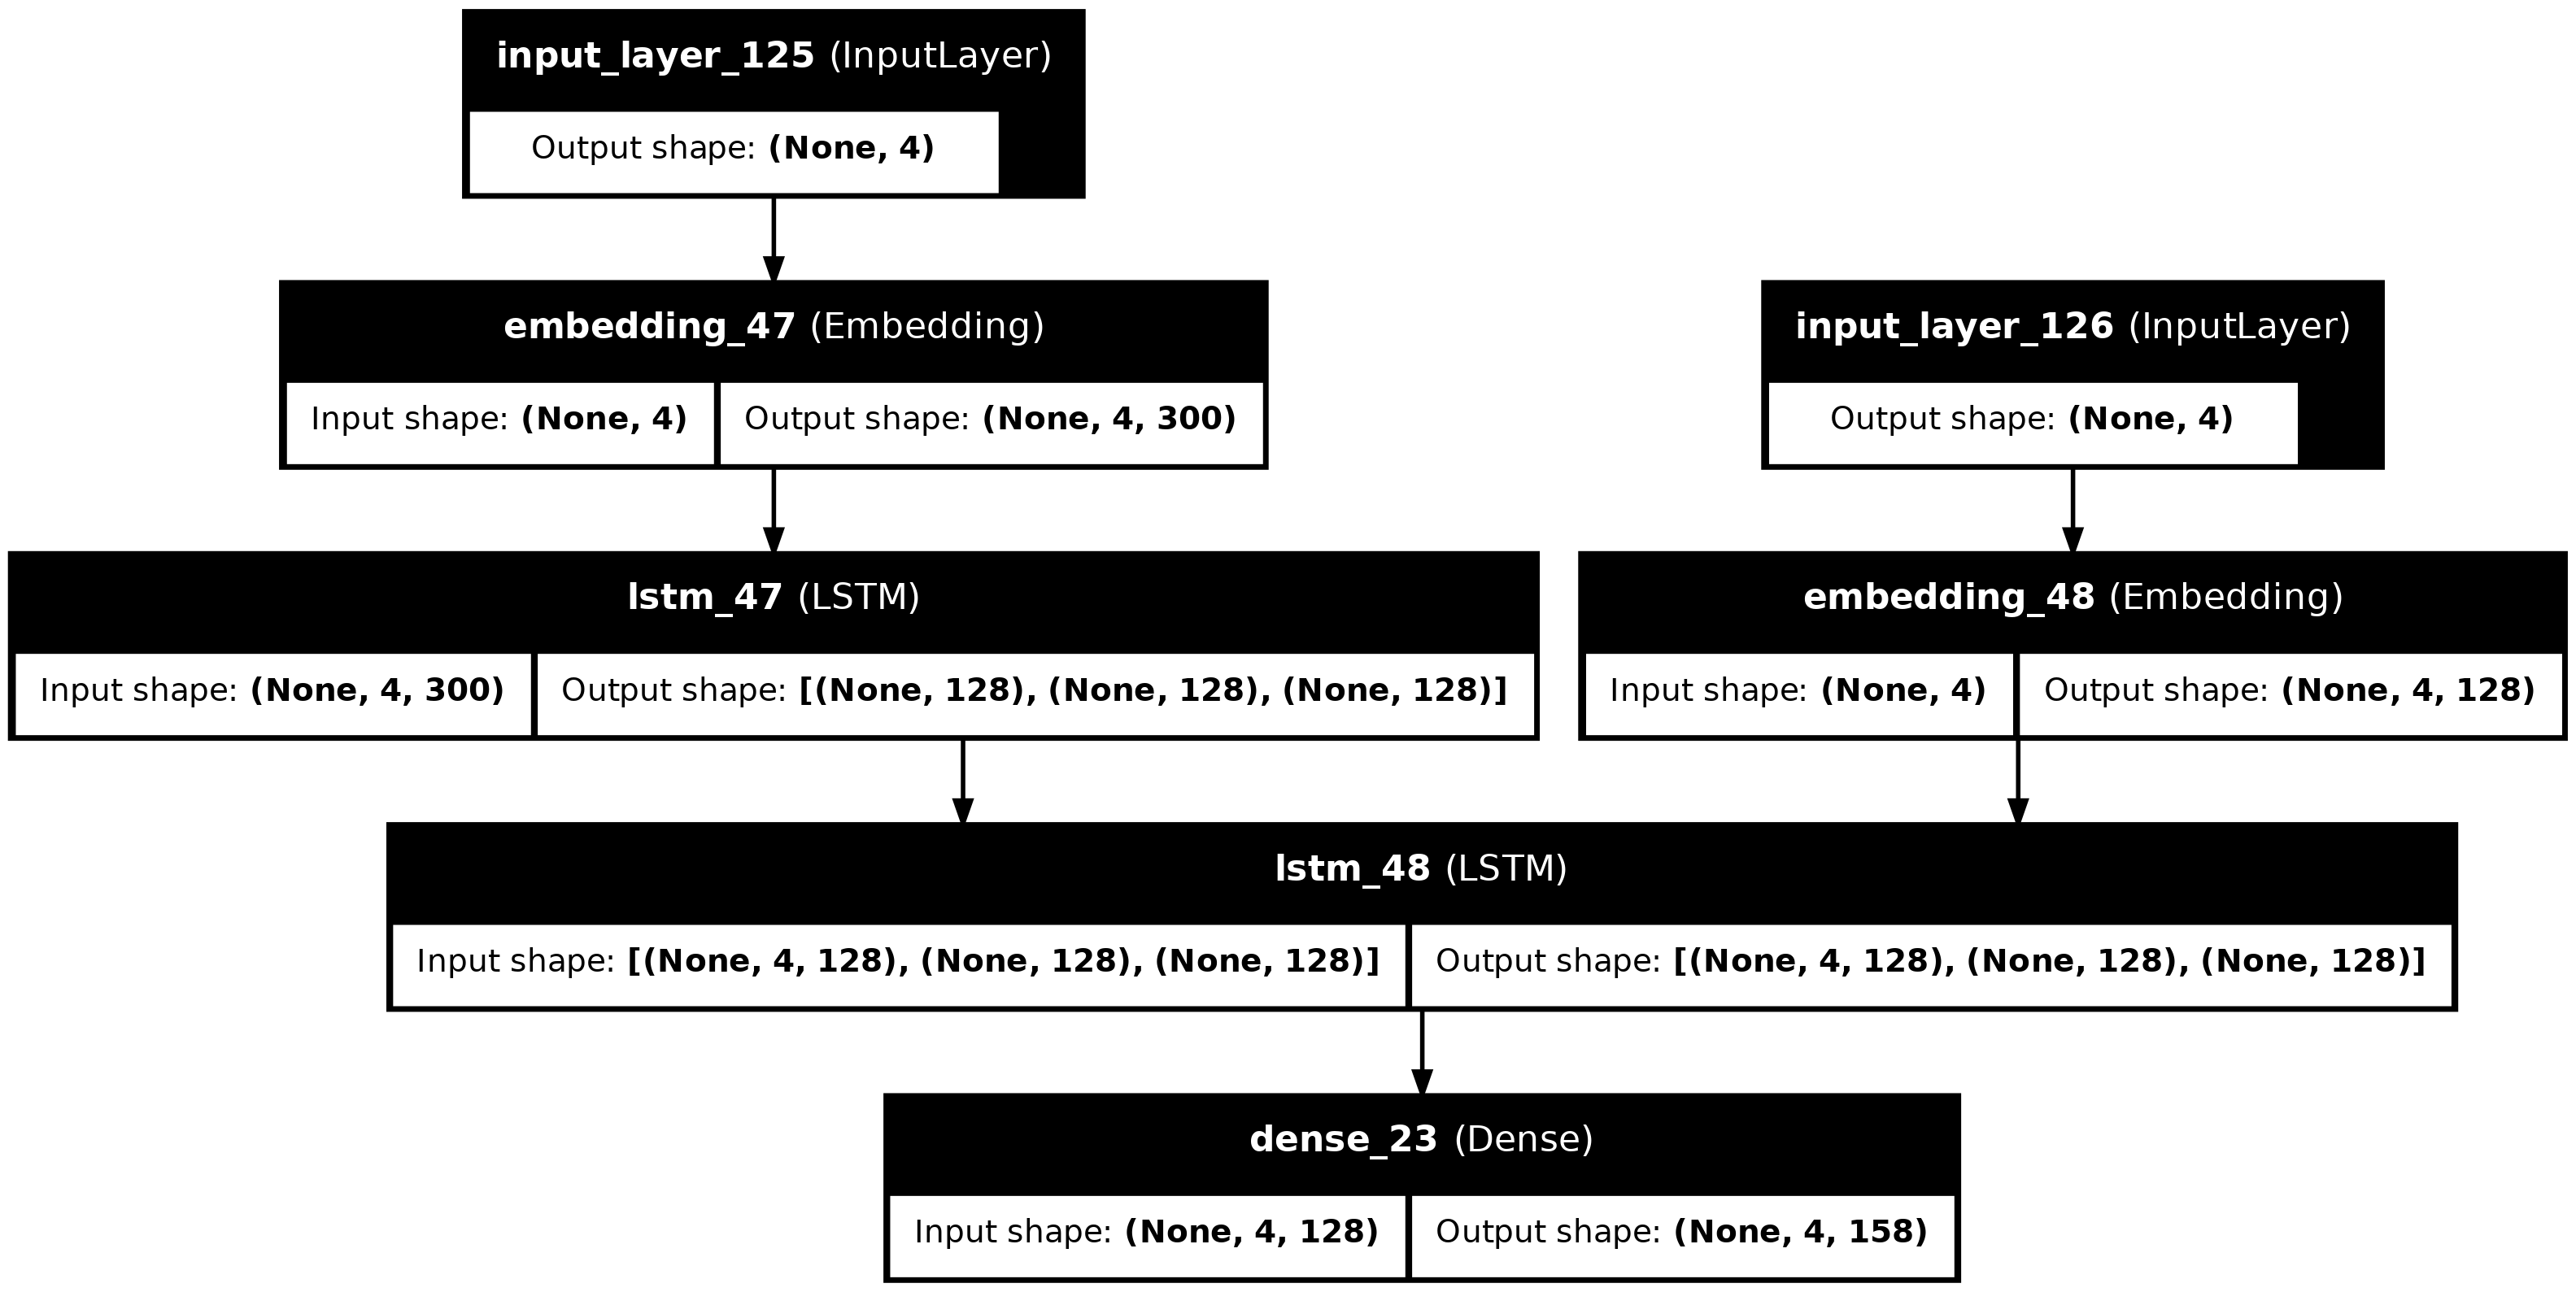

In [338]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [339]:
encoder_model = Model(encoder_inputs, encoder_states)

In [340]:
# Define the decoder's state inputs (from the encoder)
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# The decoder will receive one word at a time during inference
decoder_inputs_single = Input(shape=(1,))

# Use the same embedding layer defined during training
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# LSTM for one time step with the previous states (initial states from the encoder)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

# Updated states will be passed to the next time step
decoder_states = [state_h, state_c]

# Dense layer for generating probabilities over the output vocabulary
decoder_outputs = decoder_dense(decoder_outputs)

# Define the decoder inference model
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [341]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Early stopping to stop training if validation loss does not improve after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint('qa_bot_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Fit the model
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    callbacks=[checkpoint],
)

# Save the final model if needed (checkpoint will save the best one)
model.save('qa_bot_final_model.keras')

Epoch 1/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - categorical_accuracy: 0.0020 - loss: 5.7943
Epoch 1: val_loss improved from inf to 2.43575, saving model to qa_bot_best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - categorical_accuracy: 0.1853 - loss: 5.3563 - val_categorical_accuracy: 0.4679 - val_loss: 2.4358
Epoch 2/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_accuracy: 0.4492 - loss: 2.4737
Epoch 2: val_loss improved from 2.43575 to 2.07742, saving model to qa_bot_best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.5365 - loss: 2.4570 - val_categorical_accuracy: 0.7147 - val_loss: 2.0774
Epoch 3/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.6797 - loss: 2.1440
Epoch 3: val_loss improved from 2.07742 to 1.82448, saving model to qa_bot_best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6915 - loss: 2.0021 - val_categorical_accuracy: 0.7179 - val_loss: 1.8245
Epoch 4/50
1/3 ━━━━━━━━━━━━━━━

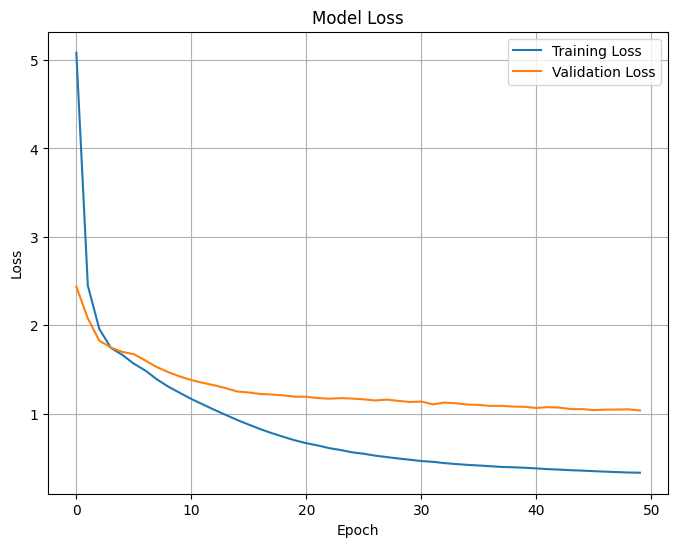

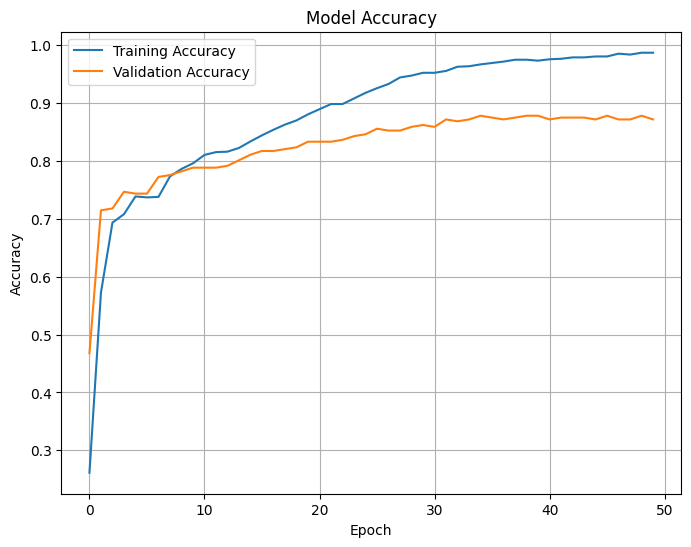

In [342]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Plot training & validation accuracy values (optional if using accuracy as a metric)
if 'categorical_accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

## Inferencia

In [343]:
idx2word_inputs = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

In [344]:
def generate_answer(input_seq):
    # Encode the input sequence to get the initial states (h, c) from the encoder
    states_value = encoder_model.predict(input_seq)

    # Initialize the decoder input sequence with the start token "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # The token representing the end of the sequence "<eos>"
    eos = word2idx_outputs['<eos>']

    output_sentence = []

    for _ in range(max_out_len):
        # Predict the next word in the sequence using the decoder
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])  # Greedy search to find the most probable word

        # If the predicted index is the end-of-sentence token "<eos>", stop the loop
        if eos == idx:
            break

        # Convert the predicted index to the corresponding word
        word = ''
        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
            
        states_value = [h, c]  # Update the states
        target_seq[0, 0] = idx  # Update the target sequence with the predicted index

    return ' '.join(output_sentence)

In [345]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = generate_answer(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
-
Input: hi
Response: command


In [346]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: My mother say hi.
Representacion en vector de tokens de ids [1]
Padding del vector: [[0 0 0 1]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Response: hiii hiii


In [347]:
input_test = "Where are you from?"
input_test_cleaned = clean_text(input_test)  # Make sure to preprocess as during training
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Generated Answer: volunteer bleat bleat bleat


In [348]:
input_test = "Do you read?"
input_test_cleaned = clean_text(input_test)  # Make sure to preprocess as during training
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Generated Answer: sup man


In [349]:
input_test = "Do you have any pet?"
input_test_cleaned = clean_text(input_test)  # Make sure to preprocess as during training
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Generated Answer: gud man man man


In [356]:
input_test = "Dance with me?"
input_test_cleaned = clean_text(input_test)  # Make sure to preprocess as during training
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Generated Answer: sup man man


In [355]:
input_test = "Have you eaten?"
input_test_cleaned = clean_text(input_test)  # Make sure to preprocess as during training
int_seq_test = input_tokenizer.texts_to_sequences([input_test_cleaned])[0]
encoder_input_test = pad_sequences([int_seq_test], maxlen=max_input_len)

# Generate the answer
answer = generate_answer(encoder_input_test)
print("Generated Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Generated Answer: sup man man
